In [2]:
%load_ext autoreload
%autoreload 2

# Model concept
![Hallo](..\sample_data\model_concept.drawio.png)

In [3]:
from helpers.log_config import setup_logging
setup_logging()

import numpy as np
import pandas as pd
import seaborn as sns
from swmm_api.output_file.extract import SwmmOutExtractWarning
import warnings
import matplotlib.pyplot as plt
import random
from src.swmmRouting.routing import Router
from src.swmmRouting.seeding import Seeder
from swmm_api.external_files.dat_timeseries import write_swmm_timeseries_data, read_swmm_timeseries_data
from swmm_api.run_swmm.run_epaswmm import swmm5_run_epa

warnings.filterwarnings("ignore", category=SwmmOutExtractWarning)

# Packet routing
This cell creates the packets and routes the packets through the hydraulic network based on the initial model run.

In [4]:
# settings for packet router
model_path = r"..\sample_data\sample_model.inp"
pop_path = r"../sample_data/pop_data.csv"
orifice_path = r"../sample_data/orifice_settings.dat"

# cleaning orifice setting data
s = read_swmm_timeseries_data(r"C:\Users\albert\PycharmProjects\PacketSWMM\sample_data\orifice_settings.dat")
s.loc[:] = 0
write_swmm_timeseries_data(s, orifice_path, drop_zeros=False)

# run model initial run
rpt_path, out_path = swmm5_run_epa(model_path)

target_node = "MH3295504178"
start = pd.to_datetime("01.04.2015 00:00", format="%d.%m.%Y %H:%M")
end = pd.to_datetime("01.06.2015 00:00", format="%d.%m.%Y %H:%M")

# pattern for distribution of defecation events, total sum of 1.5 defecations per day
# df_defpat = pd.Series(1.5 * np.array([1.4, 0.3, 0.1, 0.0, 0.3, 1.7, 9.1, 21, 13, 9, 6.9, 4.9,
#                                      1.9, 3.6, 2.5, 2, 2.9, 2.3, 4.1, 4.0, 2.7, 2.1, 2.2, 2.0])/100)
df_defpat = pd.Series(0.15 * np.array([1.4, 0.3, 0.1, 0.0, 0.3, 1.7, 9.1, 21, 13, 9, 6.9, 4.9,
                                     1.9, 3.6, 2.5, 2, 2.9, 2.3, 4.1, 4.0, 2.7, 2.1, 2.2, 2.0])/100)
# number of wipes sent per flush

# prepare seeder
df_population = pd.read_csv(pop_path)
seeder = Seeder(df_seeding_population=df_population, hourly_probability=df_defpat)
seed_table = seeder.generate_seeds(start=start, end=end)

# prepare router
router = Router()
router.get_network_from_inpfile(model_path)
router.get_flows_from_outfile(path_out=out_path, start=start, end=end)

# create seeds and route table
rtable = router.from_seeding_table(seeding_table=seed_table, target=target_node)
routed = router.route_table(rtable)

# Blockage simulation
## Prepare data for blockage simulations
### 1. Get arrivals

In [5]:
print(routed[target_node].info())
routed[target_node].head()

<class 'pandas.core.series.Series'>
RangeIndex: 7587 entries, 0 to 7586
Series name: MH3295504178
Non-Null Count  Dtype         
--------------  -----         
7478 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 59.4 KB
None


0   2015-05-13 11:17:26.575453085
1   2015-05-27 17:09:58.280437415
2   2015-05-28 14:26:11.851447955
3   2015-04-02 14:36:38.077339886
4   2015-05-13 00:32:28.108986861
Name: MH3295504178, dtype: datetime64[ns]

Total arrivals: 7463; Expected: 7478


[Text(0, 0.5, 'Arrivals per hour [1/hr]')]

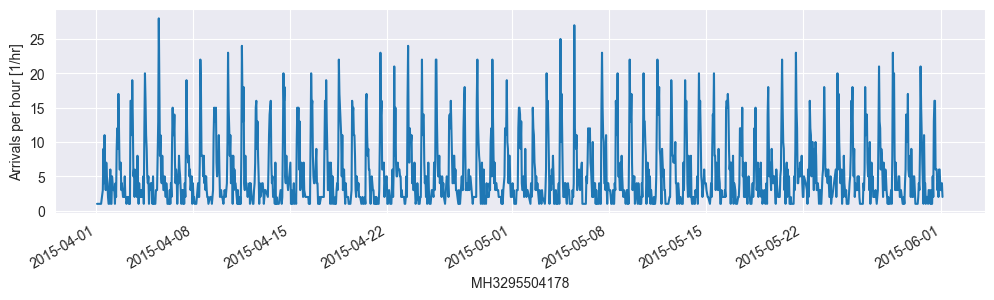

In [6]:
arrivals = routed[target_node].dropna().sort_values()
hourly_arrivals = arrivals.dt.floor("H")
s_arrivals = hourly_arrivals.groupby(hourly_arrivals).size()
s_arrivals = s_arrivals[s_arrivals.index > start]
s_arrivals.rename("arrivals", inplace=True)
print(f"Total arrivals: {s_arrivals.sum()}; Expected: {len(routed[target_node].dropna())}")

fig, ax = plt.subplots(figsize=(12, 3))
s_arrivals.plot(ax=ax)
ax.set(ylabel="Arrivals per hour [1/hr]")
# ax2 = ax.twinx()
# s_arrivals.cumsum().plot(ax=ax2, c="tab:green")
# ax2.set(ylabel="Cumulative arrivals [#]") 

### 2. Get flowrates

In [21]:
# get flowrates
s_flowrates = router.df_flows["MH3295504178.1"].resample("1h").mean().rename("flow")
df = pd.concat([s_arrivals, s_flowrates], axis=1)
# df = df.dropna()
df["arrivals"].fillna(0, inplace=True)
df

,arrivals,flow
2015-04-01 00:00:00,0.0,0.0
2015-04-01 01:00:00,1.0,0.0
2015-04-01 02:00:00,1.0,0.0
2015-04-01 03:00:00,0.0,0.0
2015-04-01 04:00:00,0.0,0.0
...,...,...
2015-05-31 22:00:00,4.0,0.0
2015-05-31 23:00:00,3.0,0.0
2015-06-01 00:00:00,3.0,0.0
2015-06-01 01:00:00,4.0,NaN


### 3 Get build-up from arrivals and flowrates

In [15]:
from blockage import snag, accumulate

accumulation = np.zeros(len(df))
pile = 0
wipes_per_flush = 0.1

for i, (idx, values) in enumerate(df.iterrows()):
    n_arrivals = (wipes_per_flush * values["arrivals"]).round(0).astype(int)
    flowrate = values["flow"]
    accumulations = 0
    # if no pile exists, calculate snagging
    while (pile == 0) & (n_arrivals > 0):
        snagged = snag(flowrate) 
        pile += snagged
        accumulations += snagged
        n_arrivals -= 1
    # calculate accumulation with remaining arriving wipes
    accumulations += sum([accumulate(flowrate) for _ in range(n_arrivals)])
    accumulation[i] = accumulations

df["accumulation"] = accumulation

In [16]:
df.head()

,arrivals,flow,buildup,blockage,orifice,accumulation
2015-04-01 01:00:00,1.0,0.0,0.0,0.000000,0.896591,0.0
2015-04-01 02:00:00,1.0,0.0,0.0,1.000000,0.832358,0.0
2015-04-01 08:00:00,1.0,0.0,0.0,1.000685,0.832315,0.0
2015-04-01 11:00:00,3.0,0.0,0.0,3.000685,0.713972,0.0
2015-04-01 12:00:00,9.0,0.0,1.0,8.001789,0.469189,1.0


Out of 7457.0 passing wipes, 5035.0 built up at the blockage


<Axes: xlabel='arrivals', ylabel='buildup'>

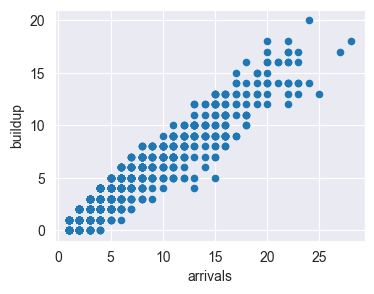

In [9]:
print(f"Out of {df['arrivals'].sum()} passing wipes, {df['buildup'].sum()} built up at the blockage")
df.plot(kind="scatter", x="arrivals", y="buildup", figsize=[4,3])

### 4. Iteratively calculate blockage size timeseries and orifice settings and simulate

In [10]:
from blockage import next_blockage, orifice_model_fitted, scaler

def calc_blockage_series(df, out_path):
    router.get_flows_from_outfile(path_out=out_path, start=start, end=end)
    df["flow"] = router.df_flows["MH3295504178.1"].resample("1h").mean()
    
    # prepare arrays
    df["pile_size"] = 0
    df["orifice"] = 1
    accumulation, flowrates, blockage, orifice = df[["accumulation", "flow", "blockage", "orifice"]].dropna().values.T
    flush_times = df.index.to_numpy()
    pile_list = []
    # calculate pile for each timestep
    for i in range(1, len(flush_times), 1):
        pile = next_blockage(pile_list[-1], flowrates[i-1], accumulation[i], flush_times[i])
        pile_list.append(pile)
    df["blockage"] = blockage
    
    # calculate orifice setting
    blockage_scaled, flowrates_scaled = scaler.transform(np.c_[blockage, flowrates]).T
    orifice = orifice_model_fitted(blockage_scaled, flowrates_scaled)
    df["orifice"] = orifice
    return df

C:\Users\albert\Projekte\ak_local\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


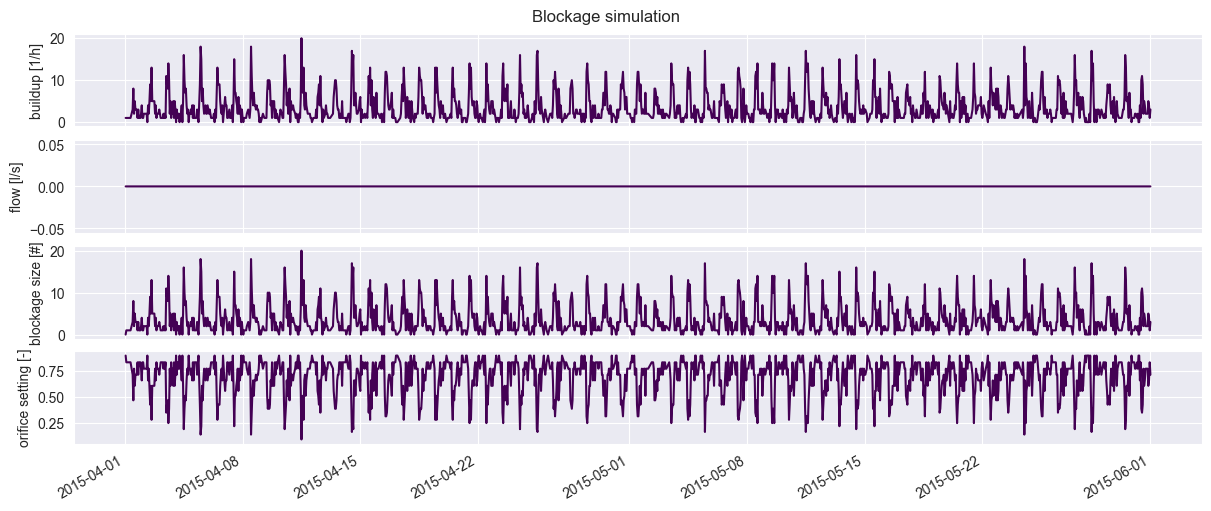

In [12]:
fig, axs = plt.subplots(figsize=[12,5], nrows=4, sharex=True, constrained_layout=True)
fig.suptitle(f"Blockage simulation")

cmap = plt.get_cmap("viridis")
i = 0
df = calc_blockage_series(df, out_path)

df["buildup"].plot(ax=axs[0], c=cmap(i))
axs[0].set(ylabel="buildup [1/h]")

df["flow"].plot(ax=axs[1], c=cmap(i))
axs[1].set(ylabel="flow [l/s]")

df["blockage"].plot(ax=axs[2], c=cmap(i))
axs[2].set(ylabel="blockage size [#]")

df["orifice"].plot(ax=axs[3], c=cmap(i))
axs[3].set(ylabel="orifice setting [-]")

write_swmm_timeseries_data(df["orifice"], r"C:\Users\albert\PycharmProjects\PacketSWMM\sample_data\orifice_settings.dat")

C:\Users\albert\Projekte\ak_local\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[Text(0, 0.5, 'orifice setting [-]')]

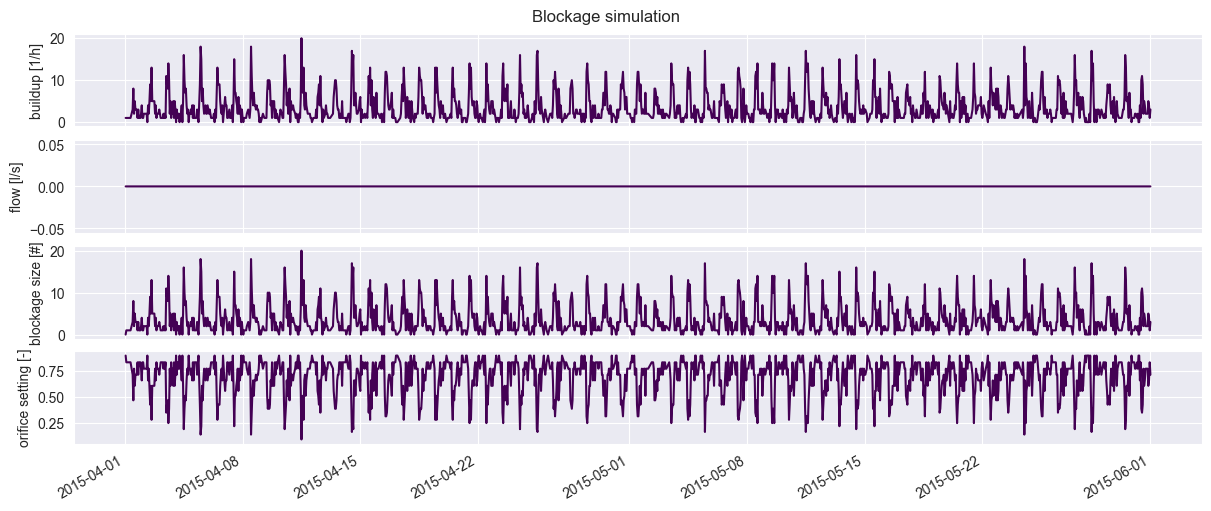

In [11]:
fn_rpt, fn_out = swmm5_run_epa(model_path)

fig, axs = plt.subplots(figsize=[12,5], nrows=4, sharex=True, constrained_layout=True)
fig.suptitle(f"Blockage simulation")

cmap = plt.get_cmap("viridis")
i = 0
df = calc_blockage_series(df, out_path)

df["buildup"].plot(ax=axs[0], c=cmap(i))
axs[0].set(ylabel="buildup [1/h]")

df["flow"].plot(ax=axs[1], c=cmap(i))
axs[1].set(ylabel="flow [l/s]")

df["blockage"].plot(ax=axs[2], c=cmap(i))
axs[2].set(ylabel="blockage size [#]")

df["orifice"].plot(ax=axs[3], c=cmap(i))
axs[3].set(ylabel="orifice setting [-]")


C:\Users\albert\Projekte\ak_local\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\albert\Projekte\ak_local\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\albert\Projekte\ak_local\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\albert\Projekte\ak_local\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\albert\Projekte\ak_local\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


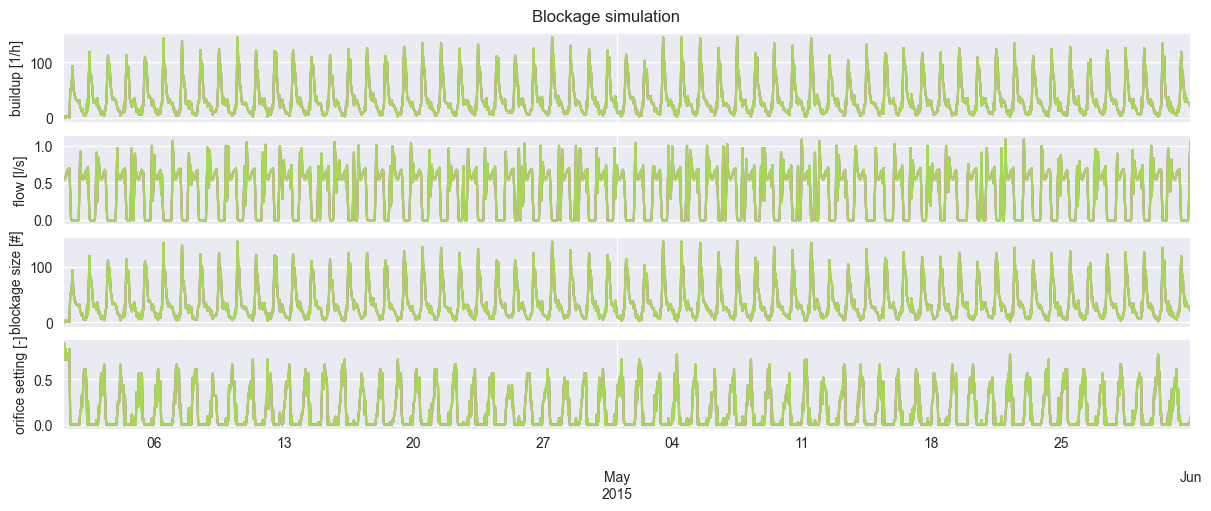

In [160]:
from swmm_api.run_swmm.run_epaswmm import swmm5_run_epa

cmap = plt.get_cmap("Set2")

fig, axs = plt.subplots(figsize=[12,5], nrows=4, sharex=True, constrained_layout=True)
fig.suptitle(f"Blockage simulation")

for i in range(5):
    df = calc_blockage_series(df, out_path)

    df["buildup"].plot(ax=axs[0], c=cmap(i))
    axs[0].set(ylabel="buildup [1/h]")
    
    df["flow"].plot(ax=axs[1], c=cmap(i))
    axs[1].set(ylabel="flow [l/s]")
    
    df["blockage"].plot(ax=axs[2], c=cmap(i))
    axs[2].set(ylabel="blockage size [#]")
    
    df["orifice"].plot(ax=axs[3], c=cmap(i))
    axs[3].set(ylabel="orifice setting [-]")
    
    write_swmm_timeseries_data(df["orifice"], r"C:\Users\albert\PycharmProjects\PacketSWMM\sample_data\orifice_settings.dat")
    fn_rpt, fn_out = swmm5_run_epa(model_path)